# 物体检测Yolo V3实践

物体检测是计算机视觉中的一个重要的研究领域，在人流检测，行人跟踪，自动驾驶，医学影像等领域有着广泛的应用。不同于简单的图像分类，物体检测旨在对图像中的目标进行精确识别，包括物体的位置和分类，因此能够应用于更多高层视觉处理的场景。例如在自动驾驶领域，需要辨识摄像头拍摄的图像中的车辆、行人、交通指示牌及其位置，以便进一步根据这些数据决定驾驶策略。本期学习案例，我们将聚焦于YOLO算法，YOLO(You Only Look Once)是一种one-stage物体检测算法。

### 进入ModelArts

点击如下链接：https://www.huaweicloud.com/product/modelarts.html ， 进入ModelArts主页。点击“立即使用”按钮，输入用户名和密码登录，进入ModelArts使用页面。

### 创建ModelArts notebook

下面，我们在ModelArts中创建一个notebook开发环境，ModelArts notebook提供网页版的Python开发环境，可以方便的编写、运行代码，并查看运行结果。

第一步：在ModelArts服务主界面依次点击“开发环境”、“创建”

![create_nb_create_button](./img/create_nb_create_button.png)

第二步：填写notebook所需的参数：

|项目|建议填写方式|
|-|-|
|名称|自定义环境名称|
|工作环境 | Python3|
| 资源池 | 选择"公共资源池"即可 |
|类型|GPU|
|规格|GPU:1*p100, CPU:8核64GiB|
|存储配置|EVS|
|磁盘规格|5GB|

第三步：配置好notebook参数后，点击下一步，进入notebook信息预览。确认无误后，点击“立即创建”

![create_nb_creation_summary](./img/create_nb_creation_summary.png)

第四步：创建完成后，返回开发环境主界面，等待Notebook创建完毕后，打开Notebook，进行下一步操作。
![modelarts_notebook_index](./img/modelarts_notebook_index.png)

### 在ModelArts中创建开发环境

接下来，我们创建一个实际的开发环境，用于后续的实验步骤。

第一步：点击下图所示的“打开”按钮，进入刚刚创建的Notebook
![inter_dev_env](img/enter_dev_env.png)

第二步：创建一个Python3环境的的Notebook。点击右上角的"New"，然后选择TensorFlow 1.13.1开发环境。

第三步：点击左上方的文件名"Untitled"，并输入一个与本实验相关的名称，如"yolo_v3"
![notebook_untitled_filename](./img/notebook_untitled_filename.png)
![notebook_name_the_ipynb](./img/notebook_name_the_ipynb.png)


### 在Notebook中编写并执行代码

在Notebook中，我们输入一个简单的打印语句，然后点击上方的运行按钮，可以查看语句执行的结果：
![run_helloworld](./img/run_helloworld.png)


开发环境准备好啦，接下来可以愉快地写代码啦！

### 数据和代码下载
运行下面代码，进行数据和代码的下载和解压

In [1]:
from modelarts.session import Session
sess = Session()

if sess.region_name == 'cn-north-1':
    bucket_path="modelarts-labs/notebook/DL_object_detection_yolo/yolo.tar"
elif sess.region_name == 'cn-north-4':
    bucket_path="modelarts-labs-bj4/notebook/DL_object_detection_yolo/yolo.tar"
else:
    print("请更换地区到北京一或北京四")

sess.download_data(bucket_path=bucket_path, path="./yolo.tar")

# 解压文件
!tar -xf yolo.tar

Successfully download file modelarts-labs/notebook/DL_object_detection_yolo/yolo.tar from OBS to local ./yolo.tar


In [2]:
!rm coco/coco_data/._*.jpg

## YOLO训练

文件路径定义

In [3]:
from train import get_classes, get_anchors
# 数据文件路径
data_path = "./coco/coco_data"
# coco类型定义文件存储位置
classes_path = './model_data/coco_classes.txt'
# coco数据anchor值文件存储位置
anchors_path = './model_data/yolo_anchors.txt'
# coco数据标注信息文件存储位置
annotation_path = './coco/coco_train.txt'
# 预训练权重文件存储位置
weights_path = "./model_data/yolo.h5"
# 模型文件存储位置
save_path = "./result/models/"

classes = get_classes(classes_path)
anchors = get_anchors(anchors_path)
# 定义类型数量和anchor数量变量
num_classes = len(classes)
num_anchors = len(anchors)

Using TensorFlow backend.


构建YOLO模型

In [4]:
import keras.backend as K
from yolo3.model import preprocess_true_boxes, yolo_body, yolo_loss
from keras.layers import Input, Lambda
from keras.models import Model
# 初始化session
K.clear_session()

input_shape = (416,416)
image_input = Input(shape=(None, None, 3))
h, w = input_shape
# 对模型预测结果形状进行定义
y_true = [Input(shape=(h//{0:32, 1:16, 2:8}[l], w//{0:32, 1:16, 2:8}[l], num_anchors//3, num_classes+5)) 
          for l in range(3)]
# 构建YOLO模型结构
model_body = yolo_body(image_input, num_anchors//3, num_classes)
# 将YOLO权重文件加载进来，如果希望不加载预训练权重，从头开始训练的话，可以将这条语句删掉
model_body.load_weights(weights_path, by_name=True, skip_mismatch=True)
# 定义YOLO损失函数
model_loss = Lambda(yolo_loss, output_shape=(1,), name='yolo_loss',
    arguments={'anchors': anchors, 'num_classes': num_classes, 'ignore_thresh': 0.5})(
    [*model_body.output, *y_true])
# 构建Model，为训练做准备
model = Model([model_body.input, *y_true], model_loss)

Instructions for updating:
Colocations handled automatically by placer.


In [5]:
# 打印模型各层结构
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
zero_paddi

训练callbacks定义

In [6]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
# 定义callbacks方法
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

读取数据

In [7]:
import numpy as np
# 训练集与验证集划分比例
val_split = 0.1
with open(annotation_path) as f:
    lines = f.readlines()
np.random.seed(10101)
np.random.shuffle(lines)
np.random.seed(None)
num_val = int(len(lines)*val_split)
num_train = len(lines) - num_val

数据读取函数

In [8]:
def data_generator(annotation_lines, batch_size, input_shape, data_path,anchors, num_classes):
    n = len(annotation_lines)
    i = 0
    while True:
        image_data = []
        box_data = []
        for b in range(batch_size):
            if i==0:
                np.random.shuffle(annotation_lines)
            image, box = get_random_data(annotation_lines[i], input_shape, data_path,random=True)
            image_data.append(image)
            box_data.append(box)
            i = (i+1) % n
        image_data = np.array(image_data)
        box_data = np.array(box_data)
        y_true = preprocess_true_boxes(box_data, input_shape, anchors, num_classes)
        yield [image_data, *y_true], np.zeros(batch_size)

def data_generator_wrapper(annotation_lines, batch_size, input_shape, data_path,anchors, num_classes):
    n = len(annotation_lines)
    if n==0 or batch_size<=0: return None
    return data_generator(annotation_lines, batch_size, input_shape, data_path,anchors, num_classes)

训练过程

In [9]:
from keras.optimizers import Adam
from yolo3.utils import get_random_data 
# 选择Adam优化器
for i in range(len(model.layers)):
    model.layers[i].trainable = True
model.compile(optimizer=Adam(lr=1e-4), loss={'yolo_loss': lambda y_true, y_pred: y_pred}) 

# 开始训练
batch_size = 16
print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, data_path,anchors, num_classes),
    steps_per_epoch=max(1, num_train//batch_size),
    validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, data_path,anchors, num_classes),
    validation_steps=max(1, num_val//batch_size),
    epochs=2,
    initial_epoch=0,
    callbacks=[reduce_lr, early_stopping])


Train on 1346 samples, val on 149 samples, with batch size 16.
Epoch 1/2
84/84 [==============================] - 114s 1s/step - loss: 13.1483 - val_loss: 12.4711
Epoch 2/2
84/84 [==============================] - 89s 1s/step - loss: 11.8715 - val_loss: 11.9518


保存训练数据

In [10]:
import os
os.makedirs(save_path)
# 保存训练模型
model.save_weights(save_path + 'trained_weights_final.h5')

## YOLO测试

打开一张测试图片

In [11]:
from PIL import Image
import numpy as np
# 测试文件路径
test_file_path = './test.jpg'
# 打开测试文件
image = Image.open(test_file_path)
image_ori = np.array(image)
image_ori.shape

(640, 481, 3)

图片预处理

In [12]:
from yolo3.utils import letterbox_image
new_image_size = (image.width - (image.width % 32), image.height - (image.height % 32))
boxed_image = letterbox_image(image, new_image_size)
image_data = np.array(boxed_image, dtype='float32')
image_data /= 255.
image_data = np.expand_dims(image_data, 0)
image_data.shape

(1, 640, 480, 3)

In [13]:
import keras.backend as K
sess = K.get_session()

构建模型

In [14]:
from yolo3.model import yolo_body
from keras.layers import Input
# coco数据anchor值文件存储位置
anchor_path = "./model_data/yolo_anchors.txt"
with open(anchor_path) as f:
    anchors = f.readline()
anchors = [float(x) for x in anchors.split(',')]
anchors = np.array(anchors).reshape(-1, 2)
yolo_model = yolo_body(Input(shape=(None,None,3)), len(anchors)//3, 80)

加载模型权重，或将weights_path替换成上一步训练得出的模型地址

In [15]:
# 模型权重存储路径
weights_path = "./model_data/yolo.h5"
yolo_model.load_weights(weights_path)

定义IOU以及score：
- IOU： 将交并比大于IOU的边界框作为冗余框去除
- score：将预测分数大于score的边界框筛选出来

In [16]:
iou = 0.45
score = 0.8

构建输出`[boxes, scores, classes]`

In [17]:
from yolo3.model import yolo_eval
input_image_shape = K.placeholder(shape=(2, ))
boxes, scores, classes = yolo_eval(
    yolo_model.output, 
    anchors,
    80, #COCO 类别数量
    input_image_shape,
    score_threshold=score, 
    iou_threshold=iou)

进行预测

In [18]:
out_boxes, out_scores, out_classes = sess.run(
    [boxes, scores, classes],
    feed_dict={
        yolo_model.input: image_data,
        input_image_shape: [image.size[1], image.size[0]],
        K.learning_phase(): 0
    })

In [19]:
class_coco = get_classes(classes_path)
out_coco = []
for i in out_classes:
    out_coco.append(class_coco[i])

In [20]:
print(out_boxes)
print(out_scores)
print(out_coco)

[[152.69942  166.27255  649.0503   459.93747 ]
 [ 68.62158   21.843073 465.66208  452.6878  ]]
[0.9838943 0.999688 ]
['person', 'umbrella']


将预测结果绘制在图片上

In [21]:
from PIL import Image, ImageFont, ImageDraw

font = ImageFont.truetype(font='font/FiraMono-Medium.otf',
                    size=np.floor(3e-2 * image.size[1] + 0.5).astype('int32'))

thickness = (image.size[0] + image.size[1]) // 300

for i, c in reversed(list(enumerate(out_coco))):
    predicted_class = c
    box = out_boxes[i]
    score = out_scores[i]

    label = '{} {:.2f}'.format(predicted_class, score)
    draw = ImageDraw.Draw(image)
    label_size = draw.textsize(label, font)

    top, left, bottom, right = box
    top = max(0, np.floor(top + 0.5).astype('int32'))
    left = max(0, np.floor(left + 0.5).astype('int32'))
    bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
    right = min(image.size[0], np.floor(right + 0.5).astype('int32'))
    print(label, (left, top), (right, bottom))

    if top - label_size[1] >= 0:
        text_origin = np.array([left, top - label_size[1]])
    else:
        text_origin = np.array([left, top + 1])

    for i in range(thickness):
        draw.rectangle(
            [left + i, top + i, right - i, bottom - i],
            outline=225)
    draw.rectangle(
        [tuple(text_origin), tuple(text_origin + label_size)],
        fill=225)
    draw.text(text_origin, label, fill=(0, 0, 0), font=font)
    del draw

umbrella 1.00 (22, 69) (453, 466)
person 0.98 (166, 153) (460, 640)


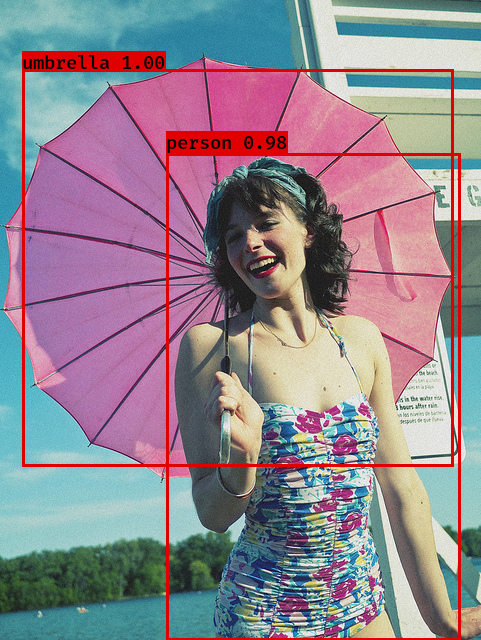

In [22]:
image